<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/ST_prediction_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

NN for predicting ST from theoretical data based on the somple model

In [1]:
!pip install lmfit
!pip install git+https://github.com/ulikoehler/UliEngineering.git


  Cloning https://github.com/ulikoehler/UliEngineering.git to /tmp/pip-req-build-tq8u2jly
  Running command git clone -q https://github.com/ulikoehler/UliEngineering.git /tmp/pip-req-build-tq8u2jly


In [2]:
import numpy as np
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd

from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  #!!! Why though? !!!

import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import io

from UliEngineering.Math.Coordinates import BoundingBox

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.

    Parameters
    ----------
    x, y - contour of the drop

    Returns
    -------
    Integrated volume using for the given shape matrix.

    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol, cal):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
#    calibration=0.00621722846441948**3
    #R_sph=(3*vol*calibration/(4*np.pi))**(1/3)
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """

    a=np.arctan2(x, y)
    return a


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, rho)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

Instructions for updating:
non-resource variables are not supported in the long term
2.6.0
Num GPUs Available:  0


Run the next code box only if google drive is not mounted to colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If it **is** mounted continue from here on

In [ ]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


### Get the data
First download the dataset!

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))
#input = pd.read_csv(csvfilename, sep="\t")
# Dataset is now stored in a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [ ]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:
import numpy as np
file1=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_20.00_Ps_2882.0.csv'), sep="\t")
file2=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_22.00_Ps_2882.0.csv'), sep="\t")
file3=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_25.00_Ps_2882.0.csv'), sep="\t")
file4=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_27.00_Ps_2882.0.csv'), sep="\t")
file5=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_30.00_Ps_2882.0.csv'), sep="\t")
file6=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_32.00_Ps_2882.0.csv'), sep="\t")
file7=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_35.00_Ps_2882.0.csv'), sep="\t")
file8=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_40.00_Ps_2882.0.csv'), sep="\t")
file9=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_45.00_Ps_2882.0.csv'), sep="\t")
file10=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_50.00_Ps_2882.0.csv'), sep="\t")
file11=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_55.00_Ps_2882.0.csv'), sep="\t")
file12=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_60.00_Ps_2882.0.csv'), sep="\t")
file13=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_65.00_Ps_2882.0.csv'), sep="\t")
file14=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_70.00_Ps_2882.0.csv'), sep="\t")
file15=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_72.00_Ps_2882.0.csv'), sep="\t")
file16=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_20.00_Rsph_0.54.csv'), sep="\t")
file17=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_22.00_Rsph_0.67.csv'), sep="\t")
file18=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_25.00_Rsph_0.59.csv'), sep="\t")
file19=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_25.00_Rsph_0.67.csv'), sep="\t")
file20=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_30.00_Rsph_0.67.csv'), sep="\t")
file21=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_35.00_Rsph_0.67.csv'), sep="\t")
file22=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_40.00_Rsph_0.80.csv'), sep="\t")
file23=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_45.00_Rsph_0.94.csv'), sep="\t")
file24=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_50.00_Rsph_1.07.csv'), sep="\t")
file25=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_55.00_Rsph_1.21.csv'), sep="\t")
file26=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_60.00_Rsph_1.34.csv'), sep="\t")
file27=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_65.00_Rsph_1.45.csv'), sep="\t")
file28=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_65.00_Rsph_1.47.csv'), sep="\t")
file29=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_70.00_Rsph_1.61.csv'), sep="\t")
file30=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_72.00_Rsph_1.61.csv'), sep="\t")

#input=np.vstack([file1, file2, file3, file4, file5, file6, file7, file8, file9, file10, file11, file12, file13, file14, file15])
#input=np.vstack([file16, file17, file18, file19, file20, file21, file22, file23, file24, file25, file26, file27, file28, file29, file30])
input=np.vstack([file1, file2, file16])
input.shape
#csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

#input = pd.read_csv(csvfilename)


(297, 304)

**Option 3**: Generate the data

Generate random angle:
20 000 sets of 200 points

(1001, 353)
1000
25.00068690001691
71.96434465280451


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

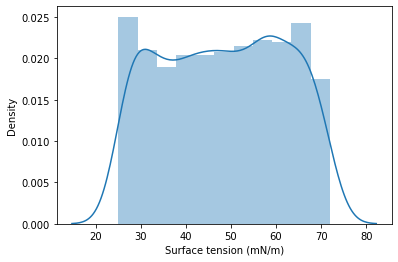

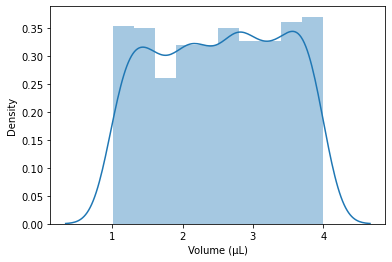

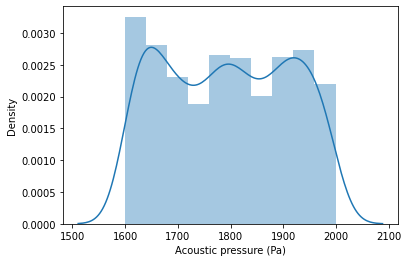

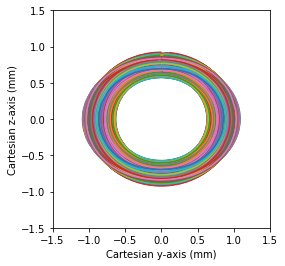

In [3]:
def gen_data(num_sample,sampling):

    np.random.seed(1234)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=np.random.random(num_sample)*(4-1)+1 # in µL
    calibration=1 #0.0060567117466506235e-3 #mm/pixel
  
    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps= np.random.random(num_sample)*(2000-1600)+1600  #[Pa]
    R_sph=calc_R_sph(vol_drop, calibration)

    # print("Radius in mm: ", R_sph)
    
    #num_sample=200  #ST
    #sampling=200

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.random.rand(num_sample, sampling)*2*np.pi
    theta.sort()
    ST_range=np.random.random(num_sample)*(72-25)+25
    # print(theta.shape)
    r_all=np.empty([0,sampling])
    # print(r_all.shape)

    if type(R_sph)==float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)==float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
          #print(r.shape)
          #print(r)
        r_all=np.vstack((r_all, r))

    dataset=np.hstack((theta,r_all, vol_drop.reshape([num_sample,1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))
    print(dataset.shape)

    if i % 1000 == 0:
      print(i)
        

    # print(r_all.shape)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    plt.figure()
    sns.distplot(ST_range)
    plt.xlabel('Surface tension (mN/m)')

    if type(vol_drop) != float:
      plt.figure()
      sns.distplot(vol_drop)
      plt.xlabel('Volume (μL)')

    if type(Ps) != float:
      plt.figure()
      sns.distplot(Ps)
      plt.xlabel('Acoustic pressure (Pa)')

    fig3 = plt.figure()
    plt.xlabel('Cartesian y-axis (mm)')
    plt.ylabel('Cartesian z-axis (mm)')
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])

    for j in dataset:
      x,y=pol2cart_theta(j[sampling:sampling+sampling], j[0:sampling])
    #  print(x.shape)
    #  print(y.shape)
      plt.plot(x,y)
    plt.show()


    return dataset

num_sample=1001  # number of different ST values
sampling=175 # number of coordiante point describing the contour


dataset=gen_data(num_sample,sampling)


column_names=[]
for i in range(sampling):
  column_names.append('theta_%d' %i)
for i in range(sampling):
  column_names.append('rho_%d' %i)
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(dataset, columns=column_names)

raw_dataset.to_csv('./dataset.csv',index=False)


In [4]:
dataset = raw_dataset.copy()

dataset.tail()

,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,theta_9,theta_10,theta_11,theta_12,theta_13,theta_14,theta_15,theta_16,theta_17,theta_18,theta_19,theta_20,theta_21,theta_22,theta_23,theta_24,theta_25,theta_26,theta_27,theta_28,theta_29,theta_30,theta_31,theta_32,theta_33,theta_34,theta_35,theta_36,theta_37,theta_38,theta_39,...,rho_138,rho_139,rho_140,rho_141,rho_142,rho_143,rho_144,rho_145,rho_146,rho_147,rho_148,rho_149,rho_150,rho_151,rho_152,rho_153,rho_154,rho_155,rho_156,rho_157,rho_158,rho_159,rho_160,rho_161,rho_162,rho_163,rho_164,rho_165,rho_166,rho_167,rho_168,rho_169,rho_170,rho_171,rho_172,rho_173,rho_174,vol,Ps,ST
996,0.019275,0.019877,0.180844,0.200666,0.205244,0.238597,0.339855,0.427002,0.429755,0.439079,0.450464,0.492680,0.502552,0.525569,0.555149,0.592976,0.649429,0.711668,0.735677,0.746079,0.833660,0.940051,0.973038,1.030929,1.059022,1.062619,1.115908,1.164074,1.230194,1.238457,1.446379,1.453893,1.552267,1.599603,1.607066,1.692726,1.695345,1.755320,1.769011,1.813414,...,1.026942,1.025158,1.014011,1.013435,1.008560,1.001663,0.999894,0.985795,0.979067,0.971210,0.965743,0.948158,0.937234,0.919438,0.915145,0.904479,0.893322,0.889892,0.887595,0.875306,0.874832,0.874181,0.873931,0.872823,0.871593,0.866393,0.862418,0.861728,0.858950,0.855074,0.852237,0.850188,0.848656,0.839086,0.838226,0.838224,0.838220,3.832614,1946.268658,42.851967
997,0.010953,0.031480,0.036125,0.043814,0.055727,0.078218,0.124267,0.126368,0.133675,0.144267,0.187567,0.193758,0.203775,0.210150,0.250128,0.259029,0.265098,0.321652,0.411367,0.424296,0.485575,0.518940,0.527233,0.549828,0.558979,0.567600,0.569680,0.586067,0.636737,0.676697,0.688423,0.726472,0.744950,0.746355,0.749926,0.782566,0.840894,0.860790,0.893368,0.911176,...,0.722934,0.721345,0.721327,0.716999,0.713656,0.712693,0.708146,0.705481,0.705012,0.704451,0.702412,0.701027,0.696740,0.696401,0.692395,0.687930,0.686492,0.686034,0.677017,0.673967,0.672291,0.667530,0.667367,0.661705,0.657144,0.654740,0.652760,0.652348,0.646146,0.645886,0.640805,0.635674,0.635530,0.635329,0.634267,0.631419,0.631102,1.393432,1981.686601,38.582218
998,0.003098,0.033754,0.092880,0.114284,0.139866,0.156848,0.163826,0.188608,0.203786,0.230928,0.286001,0.297786,0.318518,0.323449,0.341256,0.359415,0.378389,0.383536,0.446344,0.513096,0.514910,0.551641,0.582157,0.586123,0.611428,0.624286,0.652448,0.656778,0.710434,0.740044,0.767455,0.789447,0.837990,0.866300,0.883107,0.888511,1.004245,1.007801,1.020294,1.025756,...,0.880973,0.878191,0.875883,0.874095,0.873924,0.867494,0.867464,0.866782,0.865621,0.865035,0.865017,0.857819,0.856041,0.855462,0.854177,0.842884,0.842790,0.838836,0.838286,0.833883,0.828209,0.827674,0.822753,0.808860,0.808092,0.801827,0.796487,0.789947,0.785728,0.784311,0.784219,0.783021,0.781943,0.778443,0.773513,0.771441,0.767042,2.555065,1951.825903,48.494523
999,0.002335,0.050029,0.061904,0.066714,0.119377,0.145159,0.211367,0.229434,0.245022,0.249368,0.380947,0.386713,0.400298,0.411285,0.414991,0.482185,0.548723,0.569961,0.633688,0.660716,0.677234,0.704726,0.715104,0.728507,0.752095,0.764055,0.889461,0.916634,0.956502,1.041916,1.076042,1.105706,1.134099,1.136635,1.159190,1.193879,1.204298,1.226024,1.252883,1.267217,...,0.878334,0.872392,0.863845,0.860162,0.850799,0.850070,0.846802,0.840412,0.840308,0.838767,0.829038,0.821393,0.817564,0.816173,0.810218,0.798918,0.789971,0.779734,0.762282,0.760397,0.757042,0.756241,0.755398,0.754268,0.747081,0.743559,0.740022,0.738443,0.736134,0.733984,0.733971,0.732785,0.732063,0.731865,0.730500,0.730249,0.729491,2.431736,1946.384998,35.692934
1000,0.010040,0.013560,0.021569,0.062001,0.062598,0.090074,0.098188,0.104835,0.133696,0.234698,0.304421,0.358816,0.370475,0.390860,0.398393,0.406484,0.460219,0.465062,0.466176,0.508702,0.531208,0.546510,0.552152,0.570789,0.686008,0.695591,0.715240,0.720711,0.730550,0.786134,0.814316,0.827399,0.830752,0.884687,0.968064,0.969202,0.987305,1.038412,1.045103,1.068004,...,0.855192,0.859390,0.861111,0.861430,0.8617

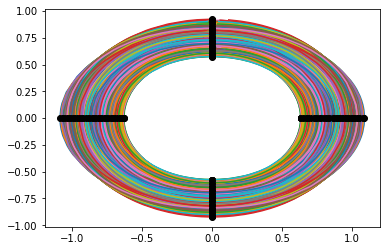

In [57]:
AR=[]

plt.figure()
for j in range(num_sample):
  x,y=pol2cart_theta(np.asarray(dataset.iloc[j, sampling:sampling+sampling]), np.asarray(dataset.iloc[j, 0:sampling]))
  plt.plot(x, y)
  plt.plot(max(x), 0, 'ko')
  plt.plot(min(x), 0, 'ko')
  plt.plot(max(y), 'ko')
  plt.plot(min(y), 'ko')
    # print(x)
  AR.append(abs(max(y)-min(y))/abs(max(x)-min(x)))

AR=np.asarray(AR)

dataset['AR']=AR

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

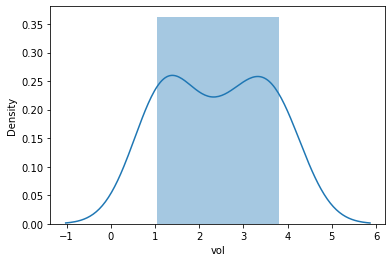

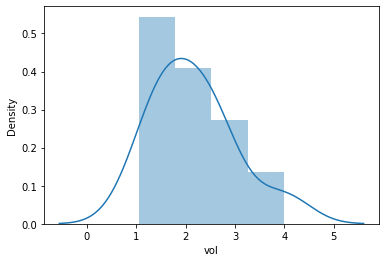

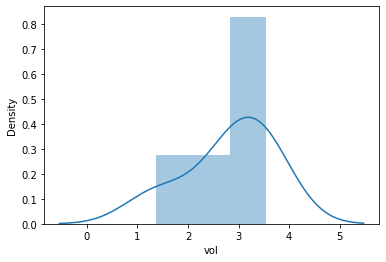

In [61]:
plt.figure()
sns.distplot(ST_1.vol)

plt.figure()
sns.distplot(ST_2.vol)

plt.figure()
sns.distplot(ST_3.vol)

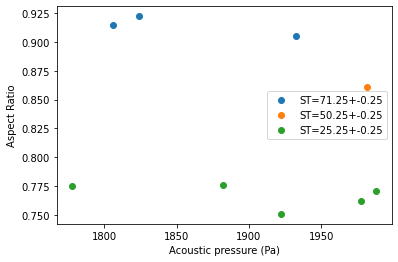

In [67]:
ST_1=dataset[(dataset['ST'] <= 72) & (dataset['ST'] > 71.5) ]
vol_1=ST_1[(ST_1['vol']<=3 ) & (ST_1['vol'] > 2)]

ST_3=dataset[(dataset['ST'] <= 50.5) & (dataset['ST'] > 50) ]
vol_3=ST_3[(ST_3['vol']<=3 ) & (ST_3['vol'] > 2)]

ST_2=dataset[(dataset['ST'] <= 25.5) & (dataset['ST'] > 25) ]
vol_2=ST_2[(ST_2['vol']<=3 ) & (ST_2['vol'] > 2)]

plt.figure()
plt.plot(vol_1.Ps, vol_1.AR, 'o', label='ST=71.25+-0.25')
plt.plot(vol_3.Ps, vol_3.AR, 'o', label='ST=50.25+-0.25')
plt.plot(vol_2.Ps, vol_2.AR, 'o', label='ST=25.25+-0.25')
plt.xlabel('Acoustic pressure (Pa)')
plt.ylabel('Aspect Ratio')
plt.legend()


###Import it using pandas for **options 1 and 2**

In [ ]:
column_names=[]

for i in range(100):
  column_names.append('rho_%d' %i)
for i in range(100):
  column_names.append('phi_%d' %i)
for i in range(100):
  column_names.append('cos2theta_%d' %i)
column_names.append('(k*R_sph)^2')
column_names.append('R_sph2')
column_names.append('Ps2*Cg_air')

column_names.append('st')

#raw_dataset = pd.read_csv(csvfilename, sep="\t")
#raw_dataset.columns=column_names

raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()


#for i in range(100):
#  dataset.pop('cos2theta_%d' %i)

dataset.pop('Ps2*Cg_air')


dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,cos2theta_63,cos2theta_64,cos2theta_65,cos2theta_66,cos2theta_67,cos2theta_68,cos2theta_69,cos2theta_70,cos2theta_71,cos2theta_72,cos2theta_73,cos2theta_74,cos2theta_75,cos2theta_76,cos2theta_77,cos2theta_78,cos2theta_79,cos2theta_80,cos2theta_81,cos2theta_82,cos2theta_83,cos2theta_84,cos2theta_85,cos2theta_86,cos2theta_87,cos2theta_88,cos2theta_89,cos2theta_90,cos2theta_91,cos2theta_92,cos2theta_93,cos2theta_94,cos2theta_95,cos2theta_96,cos2theta_97,cos2theta_98,cos2theta_99,(k*R_sph)^2,R_sph2,st
292,0.594194,0.593489,0.591385,0.587916,0.583138,0.577128,0.569983,0.561817,0.552761,0.542963,0.532578,0.521775,0.510727,0.499611,0.488608,0.477893,0.467640,0.458013,0.449166,0.441244,0.434372,0.428662,0.424205,0.421073,0.419316,0.418964,0.420020,0.422469,0.426271,0.431365,0.437669,0.445081,0.453483,0.462738,0.472698,0.483204,0.494085,0.505166,0.516270,0.527218,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
293,0.595005,0.594291,0.592158,0.588641,0.583796,0.577703,0.570458,0.562178,0.552997,0.543062,0.532534,0.521580,0.510379,0.499109,0.487953,0.477090,0.466694,0.456933,0.447964,0.439931,0.432964,0.427174,0.422655,0.419480,0.417699,0.417341,0.418413,0.420896,0.424751,0.429915,0.436307,0.443822,0.452340,0.461724,0.471822,0.482474,0.493506,0.504741,0.515999,0.527099,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
294,0.595822,0.595098,0.592935,0.589370,0.584459,0.578281,0.570936,0.562543,0.553235,0.543163,0.532489,0.521385,0.510029,0.498604,0.487293,0.476280,0.465741,0.455845,0.446753,0.438609,0.431546,0.425676,0.421095,0.417876,0.416070,0.415708,0.416794,0.419311,0.423219,0.428455,0.434935,0.442554,0.451189,0.460702,0.470940,0.481738,0.492923,0.504313,0.515727,0.526980,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
295,0.596645,0.595910,0.593718,0.590104,0.585126,0.578864,0.571418,0.562909,0.553474,0.543264,0.532444,0.521188,0.509676,0.498094,0.486629,0.475465,0.464782,0.454750,0.445533,0.437278,0.430118,0.424168,0.419524,0.416261,0.414431,0.414063,0.415164,0.417716,0.421678,0.426985,0.433554,0.441277,0.450031,0.459674,0.470052,0.480998,0.492336,0.503882,0.515452,0.526859,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
296,0.597473,0.596729,0.594507,0.590843,0.585797,0.579450,0.571903,0.563279,0.553715,0.543366,0.532399,0.520989,0.509321,0.497582,0.485961,0.474645,0.463816,0.453648,0.444306,0.435938,0.428681,0.422650,0.417943,0.414635,0.412780,0.412407,0.413523,0.416110,0.420125,0.425505,0.432163,0.439991,0.448864,0.458639,0.469158,0.480253,0.491745,0

In [ ]:
k_o=2*np.pi*20.2/340 
dataset['(k*R_sph)^2']=(dataset['(k*R_sph)^2']*k_o)**2

#Cg_air=1/103623.50  #Pa**(-1)
#dataset['Ps2*Cg_air']=dataset['Ps2*Cg_air']*Cg_air

In [ ]:
dataset.iloc[193, :]

rho_0           6.275189e-01
rho_1           6.267880e-01
rho_2           6.246516e-01
rho_3           6.211441e-01
rho_4           6.163220e-01
                    ...     
cos2theta_98    4.021315e-03
cos2theta_99    3.749399e-33
(k*R_sph)^2     4.508115e-02
R_sph2          3.235120e-01
st              2.200000e+01
Name: 193, Length: 303, dtype: float64

### Import data for **option 3**:

In [ ]:
# loading of data

raw_dataset=pd.read_csv('dataset.csv')

dataset = raw_dataset.copy()
dataset.tail()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=1)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("ST")

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
theta,40000.0,0.035441,0.035409,8.227378e-07,0.010152,0.024761,0.049136,0.398472
theta,40000.0,0.070948,0.049674,1.636472e-04,0.034155,0.059752,0.095815,0.431262
theta,40000.0,0.106703,0.060614,3.322635e-03,0.062049,0.095695,0.139350,0.483530
theta,40000.0,0.142465,0.069982,5.237236e-03,0.090981,0.131095,0.182129,0.624057
theta,40000.0,0.178111,0.078032,1.199932e-02,0.120799,0.167156,0.223681,0.703769
...,...,...,...,...,...,...,...,...
rho,40000.0,0.757438,0.084149,5.553369e-01,0.692068,0.764910,0.825379,0.931905
rho,40000.0,0.756611,0.083974,5.549933e-01,0.691518,0.764025,0.824411,0.928220
rho,40000.0,0.756066,0.083867,5.549343e-01,0.691137,0.763394,0.823737,0.927652
vol,40000.0,2.501001,0.867448,1.000078e+00,1.750726,2.499641,3.252811,3.999997


### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [ ]:
# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)
# #normed_train_data = train_dataset
# #normed_test_data = test_dataset


In [ ]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx], idx
    
# find_nearest(train_stats['std'], 0)

(0.0, 193)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

### Min-Max transformation

In [ ]:
points=175

stats = dataset.iloc[:, points*2:].describe()
stats.pop("ST")

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
vol,50000.0,2.500667,0.867762,1.000078,1.748480,2.501759,3.25216,3.999997
Ps,50000.0,1800.014129,115.310712,1600.001121,1699.839026,1799.681532,1900.05598,1999.992497


In [ ]:
max_rho=[]
min_rho=[]
min_theta=[]
max_theta=[]
for i in range(len(dataset)):
  max_rho.append(max(dataset.iloc[i, 0:points].values))
  min_rho.append(min(dataset.iloc[i, 0:points].values))
  max_theta.append(max(dataset.iloc[i, points:points*2].values))
  min_theta.append(min(dataset.iloc[i, points:points*2].values))

print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

8.227377601459501e-07 6.283185168994403 0.554932588023126 1.1029742121076611


In [ ]:
# Change the range of rho from 0 to 1

OldMax= max(max_rho)
OldMin=min(min_rho)

NewValues_rho={}

OldRange = (OldMax - OldMin)
for i in range(len(dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
      NewValues_rho[i]=NewValue

In [ ]:
# Change the range of theta from 0 to 1

OldMax= max(max_theta)
OldMin=min(min_theta)

NewValues_theta={}

OldRange = (OldMax - OldMin)
for i in range(len(dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, points:points*2] - OldMin)/(OldMax-OldMin) 
      NewValues_theta[i]=NewValue

In [ ]:
df_rho=pd.DataFrame.from_dict(NewValues_rho).T
df_theta=pd.DataFrame.from_dict(NewValues_theta).T

new_df=pd.concat([df_rho, df_theta], axis=1)

new_df.tail()

,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,...,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho
49995,0.003798,0.005456,0.005560,0.005896,0.017288,0.041396,0.042093,0.042895,0.045327,0.045687,0.046397,0.073779,0.081113,0.081361,0.084689,0.089153,0.095418,0.095456,0.099648,0.107035,0.112253,0.112511,0.115867,0.116188,0.119140,0.126929,0.141166,0.146613,0.155953,0.159222,0.159392,0.162532,0.164244,0.171529,0.177265,0.177880,0.191044,0.193746,0.200977,0.209258,...,0.754136,0.754061,0.753565,0.753473,0.751842,0.712333,0.711280,0.710846,0.689577,0.674299,0.665517,0.648736,0.593254,0.551770,0.545124,0.527128,0.523913,0.510244,0.505904,0.487085,0.479064,0.472509,0.459118,0.457701,0.434538,0.426523,0.394508,0.384910,0.360105,0.353352,0.352250,0.348993,0.348403,0.348002,0.340328,0.310548,0.293257,0.291415,0.275309,0.275032
49996,0.008172,0.022973,0.030498,0.032982,0.034260,0.039171,0.040534,0.040809,0.042631,0.043519,0.051140,0.051962,0.059372,0.060544,0.064530,0.071753,0.079368,0.081189,0.091886,0.096256,0.116782,0.120982,0.126834,0.131316,0.142547,0.147319,0.157553,0.162946,0.162961,0.166875,0.182168,0.189876,0.209391,0.220230,0.225960,0.231544,0.244047,0.244806,0.248919,0.258173,...,0.376408,0.370869,0.363683,0.362606,0.360907,0.345627,0.339316,0.337325,0.336920,0.329102,0.323769,0.320001,0.319361,0.304575,0.303700,0.301668,0.301641,0.297152,0.293691,0.292718,0.290480,0.290370,0.276845,0.258075,0.252442,0.251691,0.243166,0.241898,0.239209,0.235933,0.235118,0.233051,0.232708,0.232266,0.231288,0.228705,0.228150,0.225003,0.224913,0.224655
49997,0.008612,0.017341,0.020153,0.022033,0.027864,0.033114,0.045447,0.047699,0.050459,0.052631,0.054685,0.068178,0.071835,0.072022,0.087413,0.089314,0.091418,0.093532,0.096381,0.110174,0.113495,0.119106,0.128332,0.135035,0.145887,0.147331,0.154140,0.155770,0.162833,0.168571,0.181487,0.182462,0.183843,0.189502,0.196288,0.204214,0.209246,0.212068,0.220287,0.227867,...,0.565208,0.565300,0.565278,0.565269,0.565262,0.565228,0.561507,0.557234,0.553594,0.550596,0.547926,0.543725,0.543605,0.540582,0.535480,0.534167,0.532469,0.526457,0.512829,0.511505,0.511328,0.503899,0.496316,0.471702,0.471286,0.458673,0.456323,0.447078,0.429252,0.428982,0.426512,0.425252,0.418349,0.410064,0.409184,0.408480,0.400052,0.398538,0.398345,0.397617
49998,0.001522,0.004628,0.006973,0.013721,0.020003,0.028311,0.055580,0.066910,0.080280,0.090908,0.091208,0.091615,0.093201,0.093554,0.113169,0.121151,0.122527,0.122622,0.134007,0.148595,0.152714,0.168244,0.176207,0.178379,0.184787,0.198865,0.207233,0.214187,0.224588,0.233813,0.234835,0.235033,0.241367,0.242657,0.247768,0.263803,0.264802,0.273751,0.274696,0.275757,...,0.609599,0.609087,0.604172,0.599201,0.598903,0.593881,0.589439,0.587601,0.581689,0.581652,0.567622,0.559652,0.532019,0.529006,0.524152,0.517958,0.511870,0.506558,0.505852,0.499057,0.495577,0.492107,0.482997,0.481457,0.478395,0.478319,0.478157,0.476579,0.475471,0.472417,0.464952,0.464678,0.462671,0.459365,0.454973,0.454699,0.454552,0.452903,0.452246,0.451968
49999,0.005756,0.008886,0.019945,0.032011,0.037399,0.048163,0.054605,0.062629,0.067205,0.070691,0.071629,0.097812,0.098315,0.107421,0.108691,0.111215,0.128345,0.130318,0.132043,0.134578,0.134901,0.137716,0.137738,0.140281,0.143652,0.151058,0.153834,0.166841,0.196327,0.199216,0.209058,0.218235,0.227666,0.258769,0.266068,0.270150,0.275164,0.290099,0.290712,0.293451,...,0.766292,0.765375,0.763122,0.761982,0.760656,0.757355,0.733891,0.725006,0.723604,0.699291,0.685247,0.668802,0.652830,0.652067,0.640929,0.619797,0.617124,0.582956,0.573386,0.563392,0.524875,0.523082,0.519455,0.507595,0.498666,0.496664,0.488668,0.484017,0.479709,0.460375,0.455208,0.455107,0.451162,0.448081

Text(0.5, 0, 'Azimuth angle, θ')

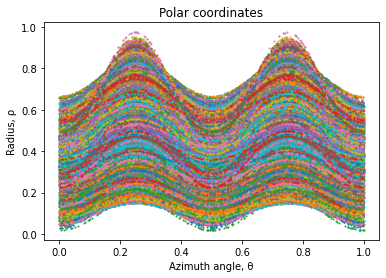

In [ ]:
plt.figure()
plt.title('Polar coordinates')
for n in range(1000):
  plt.plot(new_df.iloc[n, 0:points], new_df.iloc[n, points:points*2], 'o', markersize=1)
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')

In [ ]:
def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])

normed_data_rest = min_max_norm(dataset.iloc[:, points*2:])


In [ ]:
normed_data = new_df.copy()
normed_data['volume'] = normed_data_rest.vol
# normed_data['centre_x'] = normed_data_rest.centre_x
# normed_data['centre_y'] = normed_data_rest.centre_y
# normed_data['Aspect_Ratio'] = normed_data_rest.Aspect_Ratio

normed_data['Ps'] = normed_data_rest.Ps
# normed_data['volt'] = normed_data_rest.volt
normed_data['ST'] = dataset.ST

normed_data.tail()

,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,...,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,volume,Ps,ST
49995,0.003798,0.005456,0.005560,0.005896,0.017288,0.041396,0.042093,0.042895,0.045327,0.045687,0.046397,0.073779,0.081113,0.081361,0.084689,0.089153,0.095418,0.095456,0.099648,0.107035,0.112253,0.112511,0.115867,0.116188,0.119140,0.126929,0.141166,0.146613,0.155953,0.159222,0.159392,0.162532,0.164244,0.171529,0.177265,0.177880,0.191044,0.193746,0.200977,0.209258,...,0.753473,0.751842,0.712333,0.711280,0.710846,0.689577,0.674299,0.665517,0.648736,0.593254,0.551770,0.545124,0.527128,0.523913,0.510244,0.505904,0.487085,0.479064,0.472509,0.459118,0.457701,0.434538,0.426523,0.394508,0.384910,0.360105,0.353352,0.352250,0.348993,0.348403,0.348002,0.340328,0.310548,0.293257,0.291415,0.275309,0.275032,0.618874,0.975322,25.688378
49996,0.008172,0.022973,0.030498,0.032982,0.034260,0.039171,0.040534,0.040809,0.042631,0.043519,0.051140,0.051962,0.059372,0.060544,0.064530,0.071753,0.079368,0.081189,0.091886,0.096256,0.116782,0.120982,0.126834,0.131316,0.142547,0.147319,0.157553,0.162946,0.162961,0.166875,0.182168,0.189876,0.209391,0.220230,0.225960,0.231544,0.244047,0.244806,0.248919,0.258173,...,0.362606,0.360907,0.345627,0.339316,0.337325,0.336920,0.329102,0.323769,0.320001,0.319361,0.304575,0.303700,0.301668,0.301641,0.297152,0.293691,0.292718,0.290480,0.290370,0.276845,0.258075,0.252442,0.251691,0.243166,0.241898,0.239209,0.235933,0.235118,0.233051,0.232708,0.232266,0.231288,0.228705,0.228150,0.225003,0.224913,0.224655,0.258608,0.552953,33.849961
49997,0.008612,0.017341,0.020153,0.022033,0.027864,0.033114,0.045447,0.047699,0.050459,0.052631,0.054685,0.068178,0.071835,0.072022,0.087413,0.089314,0.091418,0.093532,0.096381,0.110174,0.113495,0.119106,0.128332,0.135035,0.145887,0.147331,0.154140,0.155770,0.162833,0.168571,0.181487,0.182462,0.183843,0.189502,0.196288,0.204214,0.209246,0.212068,0.220287,0.227867,...,0.565269,0.565262,0.565228,0.561507,0.557234,0.553594,0.550596,0.547926,0.543725,0.543605,0.540582,0.535480,0.534167,0.532469,0.526457,0.512829,0.511505,0.511328,0.503899,0.496316,0.471702,0.471286,0.458673,0.456323,0.447078,0.429252,0.428982,0.426512,0.425252,0.418349,0.410064,0.409184,0.408480,0.400052,0.398538,0.398345,0.397617,0.476843,0.360261,48.916954
49998,0.001522,0.004628,0.006973,0.013721,0.020003,0.028311,0.055580,0.066910,0.080280,0.090908,0.091208,0.091615,0.093201,0.093554,0.113169,0.121151,0.122527,0.122622,0.134007,0.148595,0.152714,0.168244,0.176207,0.178379,0.184787,0.198865,0.207233,0.214187,0.224588,0.233813,0.234835,0.235033,0.241367,0.242657,0.247768,0.263803,0.264802,0.273751,0.274696,0.275757,...,0.599201,0.598903,0.593881,0.589439,0.587601,0.581689,0.581652,0.567622,0.559652,0.532019,0.529006,0.524152,0.517958,0.511870,0.506558,0.505852,0.499057,0.495577,0.492107,0.482997,0.481457,0.478395,0.478319,0.478157,0.476579,0.475471,0.472417,0.464952,0.464678,0.462671,0.459365,0.454973,0.454699,0.454552,0.452903,0.452246,0.451968,0.563118,0.259099,52.122966
49999,0.005756,0.008886,0.019945,0.032011,0.037399,0.048163,0.054605,0.062629,0.067205,0.070691,0.071629,0.097812,0.098315,0.107421,0.108691,0.111215,0.128345,0.130318,0.132043,0.134578,0.134901,0.137716,0.137738,0.140281,0.143652,0.151058,0.153834,0.166841,0.196327,0.199216,0.209058,0.218235,0.227666,0.258769,0.266068,0.270150,0.275164,0.290099,0.290712,0.293451,...,0.761982,0.760656,0.757355,0.733891,0.725006,0.723604,0.699291,0.685247,0.668802,0.652830,0.652067,0.640929,0.619797,0.617124,0.582956,0.573386,0.563392,0.524875,0.523082,0.519455,0.507595,0.498666,0.496664,0.488668,0.484017,0.479709,0.460375,0.455208,0.455107,0.451162,0.448081,0.439334,0.435451,0.4

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [ ]:
normed_train_data = normed_data.sample(frac=0.8,random_state=0)
normed_test_data = normed_data.drop(normed_train_data.index)

Text(0.5, 0, 'Azimuth angle, θ')

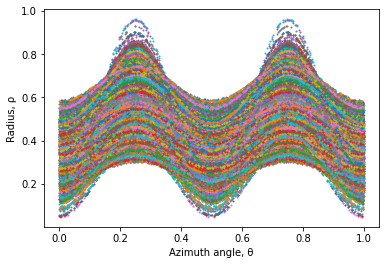

In [ ]:
plt.figure()
for i in range(1000):
  plt.plot(normed_train_data.iloc[i, 0:175], normed_train_data.iloc[i, 175:350], 'o', markersize=1)
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [ ]:
train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.softplus, input_shape=[len(normed_test_data.keys())]),
   # tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True),
   layers.Dense(25, activation=tf.nn.softplus),
    # layers.Dense(25, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.softplus),
    layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.0000001)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.0001)
  optimizer = tf.keras.optimizers.Adam() #learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False
  #optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.8, beta_2=0.995)

  #model.compile(loss='mean_squared_error',
  #              optimizer=optimizer,
  #              metrics=['mean_absolute_error', 'mean_squared_error'])
  
  model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  
  
  return model

In [ ]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 50)                17650     
_________________________________________________________________
dense_38 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_39 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 130       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 6         
Total params: 19,711
Trainable params: 19,711
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


array([[-1.3786653],
       [-1.3777649],
       [-1.3308109],
       [-1.3728629],
       [-1.3313259],
       [-1.3946002],
       [-1.3801718],
       [-1.413751 ],
       [-1.327869 ],
       [-1.3406402]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



....................................................................................................
..

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
97,0.513887,0.513887,0.510010,0.356557,0.356557,0.249031,97
98,0.540513,0.540513,0.556507,0.454199,0.454198,0.353645,98
99,0.534153,0.534153,0.540881,0.870054,0.870054,1.270933,99
100,0.515335,0.515335,0.506241,0.441538,0.441538,0.403778,100
101,0.474225,0.474225,0.426461,0.527228,0.527228,0.542847,101


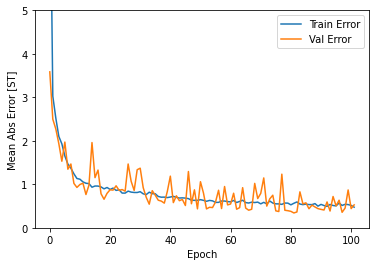

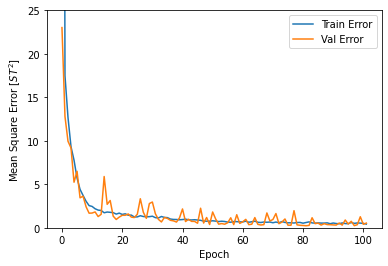

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,25])
  plt.legend()
  plt.show()


plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

print("Testing set Mean Abs Error over ST range: {:5.2f}".format(mae/(max(dataset.ST)-min(dataset.ST))))


Testing set Mean Abs Error:  0.35 mN/m
Testing set Mean Abs Error over ST range:  0.01


### Make predictions

Finally, predict ST values using data in the testing set:

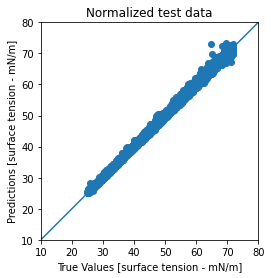

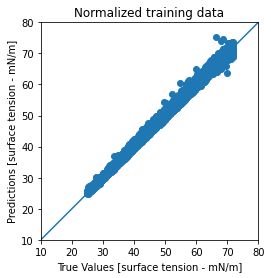

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

train_predictions = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, train_predictions)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

# plt.figure()
# plt.xlabel('Image')
# plt.ylabel('Surface tension [ mN/m ]')
# plt.ylim(30, 75)
# plt.plot(test_predictions[0:2000], label='Predicted test instances')
# plt.plot(range(len(test_labels)-18000), test_labels[0:2000], '--', label='Real test instances')
# plt.legend()


Seriously?

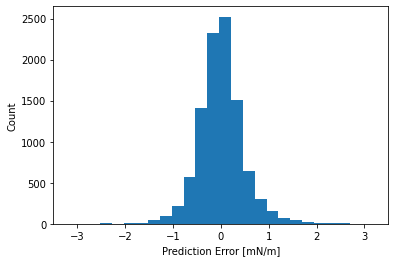

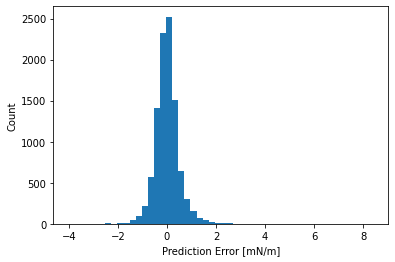

In [ ]:
error_test = test_predictions - test_labels
sns.distplot(error_test, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Density")
plt.xlim(-3.5, 3.5)
plt.show()

plt.figure()
sns.distplot(error_test, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Density")
plt.show()

## If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

del model 

model_name=str('All_surf_five_feutures_Huber_swish_trial_3.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 50)                15150     
_________________________________________________________________
dense_91 (Dense)             (None, 3)                 153       
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 4         
Total params: 15,307
Trainable params: 15,307
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.43203562],
       [-0.3725443 ],
       [ 0.15722759],
       [-0.407181  ],
       [-0.37564555],
       [-0.37614414],
       [-0.3925074 ],
       [-0.04143935],
       [ 0.6424061 ],
       [ 0.6858951 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 55 == 0: print('')
    print('.', end='')

#Save the k-th epoch (100 in this case)
#class CustomSaver(keras.callbacks.Callback):
#    filepath="/content/drive/My Drive/DropLev/MachineLearningModels/"
#    def on_epoch_end(self, epoch, logs={}):
#        if epoch == 100:  # or save after some epoch, each k-th epoch etc.
#           self.model.save(str(filepath+"SDS_70mNperm_trial1.h5"), monitor = "val_loss", verbose = 0,
#  save_best_only = False, save_weights_only = False, mode = "min", period = 1)

EPOCHS = 700

#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/saved-model-{epoch:02d}-{val_loss:.2f}.h5.h5"
#keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, 
#                                save_weights_only=False, mode='auto', period=1)
#callbacks_list = [checkpoint]

## create and use callback:
#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/weights.100EPOCHS.h5"
#saver = CustomSaver()
#history = model.fit(normed_train_data, train_labels, callbacks=[saver], epochs=10)

#Checkpoints. Save best fit
#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/weights.best.h5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='auto')
#callbacks_list = [checkpoint]

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='auto')


history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list


....................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
15,7.163245,7.163245,130.577637,7.792389,7.792389,141.851059,15
16,7.162131,7.162131,130.552383,7.785986,7.785986,141.798523,16
17,7.154714,7.154715,130.544373,7.785559,7.785559,141.747849,17
18,7.148772,7.148772,130.395157,7.756837,7.756837,141.482620,18
19,7.155182,7.155182,130.323730,7.777982,7.777982,141.616928,19


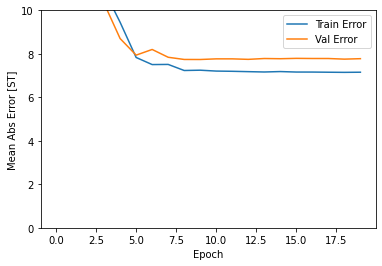

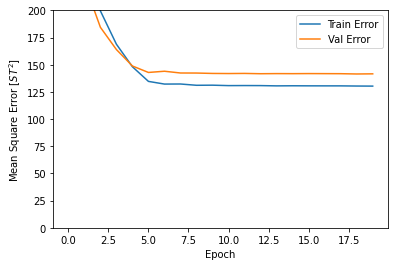

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,200])
  plt.legend()
  plt.show()


plot_history(history)

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))
# 
#keras.metrics.accuracy(normed_test_data, test_labels)

Testing set Mean Abs Error:  7.44 mN/m


### Make predictions

Finally, predict volume values using data in the testing set:

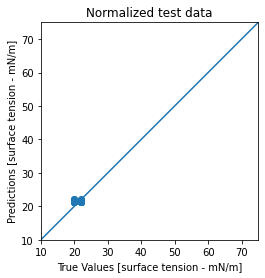

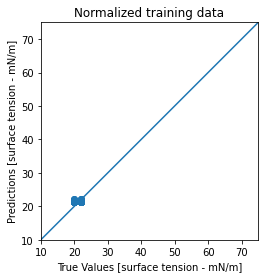

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


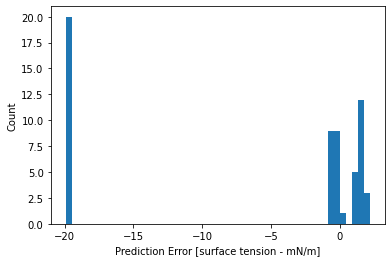

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [surface tension - mN/m]")
_ = plt.ylabel("Count")
plt.show()

# Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
filename=str('All_surf_five_feutures_Huber_swish_trial_3.h5')
!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)  #Saves the file

The SavedModel format is a directory containing a protobuf binary and a Tensorflow checkpoint. Inspect the saved model directory:

In [ ]:
# DropLev_st_prediction_model directory
#!ls content/drive/My Drive/DropLev/MachineLearningModels

# Contains an assets folder, saved_model.pb, and variables folder.
#!ls content/drive/My Drive/DropLev/MachineLearningModels/SDS_1.h5

Saving the model in a **HDF5** format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('content/drive/My Drive/DropLev/MachineLearningModels/'+filename) 

# Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)

# Check its architecture
new_model.summary()

For **HDF5** format

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('DropLev_st_prediction_model.h5')

# Show the model architecture
new_model.summary()

Evaluate the restored model (for both formats)

In [ ]:
# Evaluation
loss, mae, mse = new_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))

print(new_model.predict(normed_test_data).shape)